# Fonctions

In [30]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython.display import Audio

## Split to keep first seconds

In [31]:
'''
Objective : Split audio tensor to keep only first seconds
Input : AudioIOTensor
Output : tf.Tensor
'''

TARGET_SPLIT_DURATION_SEC = 10

def split_audio(audio):
    # Get split index adequate to audio rate
    split_index = audio.rate.numpy() * TARGET_SPLIT_DURATION_SEC
    # Split if audio length > split_index
    if audio.shape.numpy()[0] > split_index :
        return audio[:split_index]
    return audio[:]

## Reduce dimension

In [32]:
'''
Objective : Harmonize tensor shape and dtype of audio to shape (x,),dtype=float32
Input : tf.Tensor shape (x,2) stereo or (x,1) mono
Output : tf.Tensor shape(x,)
'''

def harmonize_tensor_shape(audio):
    # Convert to float32 dtype if necessary
    if audio.dtype == tf.int16 :
        audio = tf.cast(audio, tf.float32) / 32768.0
    # Convert stero to mono if adequate :
    if audio.shape[1] == 2 :
        return tf.reduce_mean(audio, 1)
    # Remove last dimension if mono sound
    return tf.squeeze(audio, axis=[-1])

## Spectrogram

In [33]:
'''
Objective : Generate spectrogram
Input : Audio tf.Tensor shape(x,)
Ouput : Spectrogram tf.Tensor shape (x,y)
'''
# On transpose pour avoir une shape similaire à celle de librosa en sortie
def generate_spectrogram(audio,nfft=4096,window=256,stride=256):
    spectrogram = tfio.audio.spectrogram(
        audio,
        nfft=nfft,
        window=window,
        stride=stride)
    return tf.transpose(spectrogram, perm=[1, 0])

## Plot spectrogram

In [107]:
def plot_spectrogram(path):
    audio = tfio.audio.AudioIOTensor(path)
    spectrogram = generate_spectrogram(
        harmonize_tensor_shape(
            split_audio(audio)
        ))
    title = f"""{(path.split('/')[-1].split('_tens.ogg')[0]).upper()}
    - audio shape: {audio.shape} - 
    - audio rate: {audio.rate} -
    - split audio shape: {split_audio(audio).shape} - 
    - harmonized shape: {harmonize_tensor_shape(split_audio(audio)).shape} -
    """
    plt.imshow(tf.math.log(spectrogram).numpy())
    # plt.imshow((spectrogram).numpy())
    plt.title(title, fontsize=10),
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8);

# Dataset's spectrograms ?

In [61]:
import pandas as pd

In [62]:
root_path = '../raw_data/data_30s/train/'

In [63]:
y_train = pd.read_csv(root_path + 'y_train.csv')
print(y_train.shape)
y_train.head(3)

(1650, 2)


,Path,Target
0,Sonus-naturalis-447407_tens.ogg,0
1,Sonus-naturalis-387437_tens.ogg,0
2,Sonus-naturalis-383228_tens.ogg,0


In [64]:
y_train.groupby(by='Target').count().head(3)

,Path
Target,
0,33
1,33
2,33


In [65]:
sub_path_list = [root_path + y_train.loc[i, 'Path'] for i in range(0, len(y_train), 33)]
sub_path_list[:5]

['../raw_data/data_30s/train/Sonus-naturalis-447407_tens.ogg',
 '../raw_data/data_30s/train/Fringilla-coelebs-180001_tens.ogg',
 '../raw_data/data_30s/train/Parus-major-361594_tens.ogg',
 '../raw_data/data_30s/train/Turdus-merula-207245_tens.ogg',
 '../raw_data/data_30s/train/Turdus-philomelos-184278_tens.ogg']

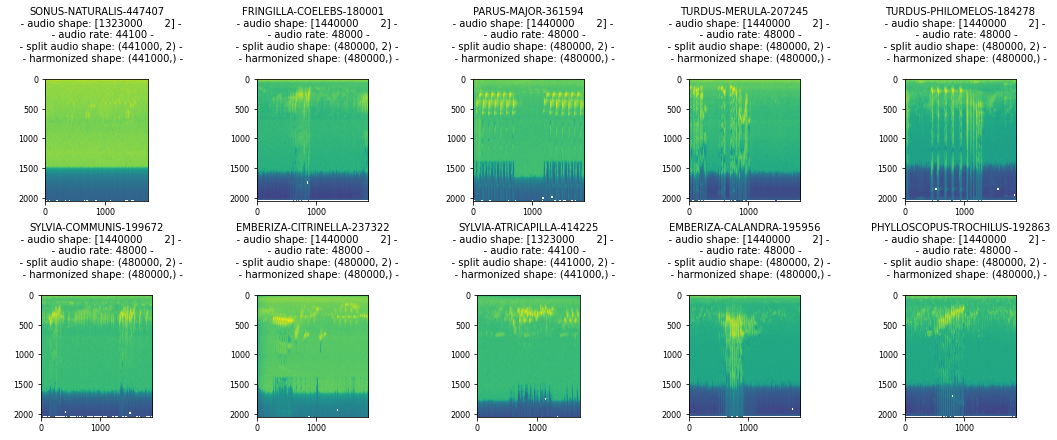

In [108]:
n_rows = 2

plt.figure(figsize=(15, 3*n_rows), constrained_layout=True)

for i in range(n_rows):
    for j in range(5):
        plt.subplot(n_rows, 5, 5*i + j + 1)
        plot_spectrogram(sub_path_list[5*i + j])